# DSClub 1: Introduction into pytorch

## PyTorch

In [25]:
import torch
import numpy as np

### Creating tensors

In [27]:
x = torch.Tensor(5, 3)
print("Non-initialized tensor x: {0}".format(x))
print("Size: {0}\n\n".format(x.size()))

y = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])
print("Manually initialized tensor y: {0}".format(y))
print("Size: {0}\n\n".format(y.size()))

z = torch.rand(2, 4)
print("Ramdomly initialized tensor z: {0}".format(z))
print("Size: {0}\n\n".format(z.size()))

Non-initialized tensor x: 
 0.0000e+00  0.0000e+00  1.4111e-19
 4.5877e-41  1.3529e-19  4.5877e-41
 1.5577e-12  4.5877e-41  1.5577e-12
 4.5877e-41  1.5577e-12  4.5877e-41
 8.9683e-44  0.0000e+00  4.6894e+27
[torch.FloatTensor of size 5x3]

Size: torch.Size([5, 3])


Manually initialized tensor y: 
 1  2  3
 4  5  6
 7  8  9
[torch.FloatTensor of size 3x3]

Size: torch.Size([3, 3])


Ramdomly initialized tensor z: 
-0.3200 -0.6171  0.1009 -1.5712
 0.2165  0.1823 -0.9139 -0.2178
[torch.FloatTensor of size 2x4]

Size: torch.Size([2, 4])




### Basic operators

In [3]:
# Tensors can be summed and multiplied by constant
ones = torch.ones(3,4)
print('ones: {0}'.format(ones))

fours = ones * 4
print('fours: {0}'.format(fours))

fives = ones + fours
print('fives: {0}'.format(fives))

In [6]:
a = torch.rand(2,3)
b = torch.rand(3,4)

# Matrix multiplication:
c = torch.mm(a,b)

print('a x b = {0}'.format(c))

### Broadcasting

In [7]:
a = torch.ones(2,5)
b = torch.ones(2,1) * 3.3

# b of size (2, 1) is broadcasted to size (2,5)
c = a + b
print("c: {0}".format(c))

In [31]:
W = torch.rand(3, 5) # weights
X = torch.ones(5, 10) * 3 # data
b = torch.ones(3, 1) * 0.3 # biases, broadcastable to WX.size()

# WX+b
A = torch.addmm(b, W, X)

print("A: {0}".format(A))

A: 
 8.2086  8.2086  8.2086  8.2086  8.2086  8.2086  8.2086  8.2086  8.2086  8.2086
 9.2379  9.2379  9.2379  9.2379  9.2379  9.2379  9.2379  9.2379  9.2379  9.2379
 7.0263  7.0263  7.0263  7.0263  7.0263  7.0263  7.0263  7.0263  7.0263  7.0263
[torch.FloatTensor of size 3x10]



###  PyTorch-Numpy interaction

In [11]:
a = np.ones((2, 3))        # create numpy array
a_pt = torch.from_numpy(a) # convert to PyTorch tensor


# a and a_pt share the same memory: if a is changed, a_pt also changes and vice versa
a[1,1] = 57
print("a_pt: {0}".format(a_pt))

In [12]:
b = torch.ones(3,3) * 7.
b_np = b.numpy()

# likewise, b and b_np share same memory
b[1,2] = 57
print("b_np: {0}".format(b_np))

### Autograd

Autograd is a module that allows to compute gradients automatically (suddenly, right?).

Lets implement easist use-case of Autograd:
* declare initial tensor 'x' (that we want to 'learn' for example)
* perform some computations on it and calculate final tensor 'out'
* automatically calculate derivative d(out)/d(x)

In [3]:
from torch.autograd import Variable

In [13]:
x = Variable(torch.ones(2, 2), requires_grad=True) # requires_grad=True so we want to compute gradient of it

# some computations
y = x + 2
z = y * y * 3
out = z.mean()

# calculate d(out) / d(x)
out.backward() 

# Tadaa
print("d(out)/d(x) = {0}".format(x.grad)) 

### Lets classify stuff!

#### Load data

First, load CIFAR dataset using code below. It consists of 60K 32x32 images (50K for training set and 10K for test set) and can be classified into 10 classes.

In [72]:
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.nn import Module, Linear, ModuleList, Sequential


In [73]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  dog  ship  deer   cat


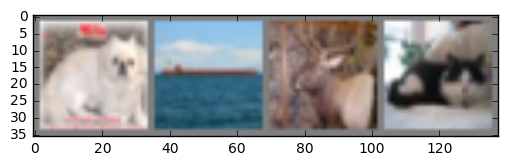

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [74]:
train_size = trainset.train_data.shape[0]
test_size = testset.test_data.shape[0]

X_train = Variable(torch.from_numpy(trainset.train_data.reshape(train_size, -1))).float()
y_train = Variable(torch.Tensor(trainset.train_labels).long())


X_test = Variable(torch.from_numpy(testset.test_data.reshape(test_size, -1))).float()
y_test = Variable(torch.Tensor(testset.test_labels).long())

input_dims = X_train.size()[1]
output_dims = len(classes)

print("Data dimensionality: {0}".format(input_dims))
print("Number of classes: {0}".format(output_dims))

Data dimensionality: 3072
Number of classes: 10


Warmup: print out tensor sizes of X_train and y_train:

In [14]:
X_train_size = None
y_train_size = None

print("X_train size: {0}".format(X_train_size))
print("y_train size: {0}".format(y_train_size))

Now, let's build the simpliest machine learning model for data classification: logistic regression.
Of course, PyTorch has a built-it function for it, but first, let's try to implement our own LogReg module to understand how PyTorch Modules work.

In [15]:
class LogReg(Module):
    
    def __init__(self):
        super(LogReg, self).__init__()
        
        # Create W matrix, it should me a Variable created from a random tensor of shape (input_dims x output_dims)
        self.W = None
        
        # Initialize biases with a Variable of zeros of size (1 x output_dims)
        self.b = None

    # parameters are those wariables that you want to optimize. Usually, this method is created for us autometically.
    def parameters(self):
        return [self.W, self.b]
        
    def forward(self, x):
        # Use torch.addmm() to compute xW + b
        x = None
        return x
        

In [49]:
# create object of our model
logr = LogReg()

In [78]:
# loss function
criterion = torch.nn.CrossEntropyLoss()

# optimizer that optimizes parameters of our model
optimizer = optim.Adam(logr.parameters(), lr=0.0001)

Now it's time to train our model!

In [16]:
for i in range(1000):
    # zero gradients before each time we are to compute them
    optimizer.zero_grad()
    
    # calculate training predictions
    preds = logr(X_train)

    # calculate loss
    loss = criterion(preds, y_train)
    
    # compute gradients
    loss.backward()
    
    # and optimize them
    optimizer.step()
    
    if i % 10 == 9:
        preds_test = logr(X_test)
        loss_test = criterion(preds_test, y_test)
        
        _, predicted = torch.max(preds_test, 1)
        accuracy = (predicted.data == y_test.data).sum() / test_size

        print('[{0}] test loss: {1} \t test accuracy: {2}'.format(i, loss_test.data[0], accuracy))

#### More idiomatic logistic regression.

And here is how it can be done in one line. It also works faster than by-hands implementation.

In [17]:
logistic_regression = nn.Linear(input_dims, output_dims)

In [81]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(logistic_regression.parameters(), lr=0.0001)

In [18]:
for i in range(1000):
    # zero gradients before each time we are to compute them
    optimizer.zero_grad()
    
    # calculate training predictions
    preds = logistic_regression(X_train)

    # calculate loss
    loss = criterion(preds, y_train)
    
    # compute gradients
    loss.backward()
    
    # and optimize them
    optimizer.step()
    
    if i % 10 == 9:
        preds_test = logistic_regression(X_test)
        loss_test = criterion(preds_test, y_test)
        _, predicted = torch.max(preds_test, 1)
        accuracy = (predicted.data == y_test.data).sum() / test_size

        print('[{0}] test loss: {1} \t test accuracy: {2}'.format(i, loss_test.data[0], accuracy))

#### 2. Two layers nn

Now to something more complex. Each linear module that we used to implement logistic regression can be used as a layer of a multilayer perceptron. Let's build two-layer MLP with one hidden layer and one output layer.

Tip: Peek at the one-line logistic regression implementation.

In [83]:
class TwoLayerNN(Module):
    def __init__(self, n_x, n_h, n_y):
        super(TwoLayerNN, self).__init__()
        
        # linear module that maps vectors of size n_x to n_h
        self.lin1 = None
        
        # same for dimensionalities n_h and n_y
        self.lin2 = None
        
    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = self.lin2(x)
        return x

In [84]:
# Create an object of 2-layer MLP with 128 hidden units.
twolayernn = None

In [85]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(twolayernn.parameters(), lr=0.0001)

In [19]:
for i in range(1000):
    # zero gradients before each time we are to compute them
    optimizer.zero_grad()
    
    # calculate training predictions
    preds = twolayernn(X_train)

    # calculate loss
    loss = criterion(preds, y_train)
    
    # compute gradients
    loss.backward()
    
    # and optimize them
    optimizer.step()
    
    if i % 10 == 9:
        preds_test = twolayernn(X_test)
        loss_test = criterion(preds_test, y_test)
        _, predicted = torch.max(preds_test, 1)
        accuracy = (predicted.data == y_test.data).sum() / test_size

        print('[{0}] test loss: {1} \t test accuracy: {2}'.format(i, loss_test.data[0], accuracy))

#### Multilayer perceptron

Next step is to create MLP with arbitrary number of layers. For that purpose we can use a module called Sequential

    self.seq = Sequential()

After that you can add modules to it that will sequentially process you data:

    self.seq.add_module("Module name", *module*)

In [36]:
class MLP(Module):
    
    # layer_dims is a list of layer's dimensionalities starting from input data dimensionality
    # e.g. for previout example it would be [input_dims, 128, output_dims]
    def __init__(self, layer_dims):
        super(MLP, self).__init__()
        
        
        nlayers = len(layer_dims)
        self.seq = Sequential()
        
        modules = []
        for l in range(1, nlayers): 
            
            # Add a Linear module of dimensionalities from layer_dims
            # TODO: (One line)
            
            if l != nlayers - 1:
                self.seq.add_module("Tanh{0}".format(l), torch.nn.Tanh())

                
        
        
    def forward(self, x):
        x = self.seq(x)
        return x

In [37]:
mlp = MLP([input_dims, 128, 64, output_dims])

In [38]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0001)

In [20]:
for i in range(1000):   

    # zero gradients before each time we are to compute them
    optimizer.zero_grad()
    
    # calculate training predictions
    preds = mlp(X_train)

    # calculate loss
    loss = criterion(preds, y_train)
    
    # compute gradients
    loss.backward()
    
    # and optimize them
    optimizer.step()

    if i % 10 == 9:
        preds_test = mlp(X_test)
        loss_test = criterion(preds_test, y_test)
        _, predicted = torch.max(preds_test, 1)
        accuracy = (predicted.data == y_test.data).sum() / test_size

        print('[{0}] test loss: {1} \t test accuracy: {2}'.format(i, loss_test.data[0], accuracy))

#### Convolutional net

Here is a idiomatic way to classify images -- use convolutional neural networks!

If you are aquainted with CNNs it would be easy to guess what Conv2d and MaxPool2d layers do.

This code is taken from official tutorial: http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Run it and see how better convolutional model works for images than MLP

In [9]:
class ConvNet(Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
convnet = ConvNet()

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(convnet.parameters(), lr=0.0001)

In [21]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = convnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [44]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = convnet(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %
